In [27]:
import os
import sys
import csv

import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict

%matplotlib inline

In [28]:
ukbb_data_file = 'data/04252020_ukb_snp_table_1.csv'

In [29]:
fh = open(ukbb_data_file)
reader = csv.reader(fh)
header = next(reader)

ukbb_data = list()

for row in reader:
    ukbb_data.append(dict(zip(header, row[:2] + list(map(int,row[2:])))))

In [30]:

# construct an rsid->gene mapping
rsid2gene = defaultdict(set)
genes = set()

snp_allele_counts = dict()

for row in ukbb_data:
    rsid2gene[row['rsid']].add(row['gene'])
    snp_allele_counts[row['rsid']] = row
    genes.add(row['gene'])

In [32]:
study = 'pos_severe'
# study = 'pos'
# study = 'neg'

plink_results_file = 'data/%s.PHENO1.glm.logistic.adjusted' % study
plink_details_file = 'data/%s.PHENO1.glm.logistic' % study

In [33]:
fh = open(plink_details_file)
reader = csv.reader(fh, delimiter='\t')
header = next(reader)

plink_details = dict()
for row in reader:
    row = dict(zip(header, row))
    if row['TEST'] == 'ADD':
        plink_details[row['ID']] = row

len(plink_details), list(plink_details.items())[0]

(2097,
 ('rs61775589',
  {'#CHROM': '1',
   'POS': '11028301',
   'ID': 'rs61775589',
   'REF': 'C',
   'ALT': 'T',
   'A1': 'C',
   'TEST': 'ADD',
   'OBS_CT': '337147',
   'OR': '1.09774',
   'LOG(OR)_SE': '0.151293',
   'Z_STAT': '0.616386',
   'P': '0.53764'}))

In [34]:
fh = open(plink_results_file)
reader = csv.reader(fh, delimiter='\t')

header = next(reader)
print(header)

plink_results = list()

for row in reader:
    chrom = row[0]
    rsid = row[1]
    allele = row[2]
    unadjusted = float(row[3])
    fdrbh = float(row[9])
    
    plink_results.append([chrom, rsid, allele, unadjusted, fdrbh])

len(plink_results)

['#CHROM', 'ID', 'A1', 'UNADJ', 'GC', 'BONF', 'HOLM', 'SIDAK_SS', 'SIDAK_SD', 'FDR_BH', 'FDR_BY']


2097

## Pull out and build a table from the study-wide significant hits

In [36]:
gt_types = ["%s_ref/ref_count", "%s_ref/alt_count", "%s_alt/alt_count"]

genotype_counts_keys = [t % 'all' for t in gt_types] + [t % study for t in gt_types]

ofh = open('results/table3_ukbb_results_%s.csv' % study, 'w')
writer = csv.writer(ofh)

sig_chroms = set()

results_header = ["rsid", "chrom", "pos", "ref", "alt", "OR", "log(OR)se", "z_stat", "allele", "unadjusted", "FDR_BH", "genes"] + genotype_counts_keys 
writer.writerow(results_header)
least_sig_sig = None

marginally_significant_table = list()

for chrom, rsid, allele, unadjusted, fdrbh in plink_results:
    details = plink_details[rsid]
    genotype_counts = [snp_allele_counts[rsid][k] for k in genotype_counts_keys]
        
    if fdrbh < 0.05:
        if least_sig_sig is None or unadjusted > least_sig_sig:
            least_sig_sig = unadjusted
        
        writer.writerow([rsid, chrom, details['POS'], details['REF'], details['ALT'], details['OR'], details['LOG(OR)_SE'], details['Z_STAT'], allele, unadjusted, fdrbh, ','.join(rsid2gene[rsid])] + genotype_counts)
        print(rsid, chrom, details['POS'], details['REF'], details['ALT'], details['OR'], details['LOG(OR)_SE'], details['Z_STAT'], allele, unadjusted, fdrbh, ','.join(rsid2gene[rsid]))
        sig_chroms.add(int(chrom))
    
    if unadjusted < 1e-2:
        marginally_significant_table.append(
            [rsid, chrom, details['POS'], details['REF'], details['ALT'], details['OR'], details['LOG(OR)_SE'], details['Z_STAT'], allele, unadjusted, fdrbh, ','.join(rsid2gene[rsid])] + genotype_counts            
        )
        

ofh.close()

ofh = open('results/table4_ukbb_results_marginally_sig_%s.csv' % study, 'w')
writer = csv.writer(ofh)
writer.writerow(results_header)
writer.writerows(marginally_significant_table)
ofh.close()

rs45574833 1 207300070 A G 2.64776 0.222419 4.37783 A 1.19866e-05 0.00455492 C4BPB,C4BPA
rs61821114 1 207610967 T C 2.39526 0.212492 4.1107 T 3.94457e-05 0.00749468 CR1,CR2
rs61821041 1 207352581 G A 2.3377 0.233369 3.63874 G 0.00027397 0.032234 C4BPA
rs12064775 1 196600605 G A 2.13153 0.212588 3.56012 G 0.000370689 0.032234 CFH
rs72729504 1 94940206 T C 1.93339 0.18705 3.52459 T 0.000424132 0.032234 F3
rs117284601 11 57425228 A G 1.80043 0.151694 3.87638 A 0.000106022 0.00742154 SERPING1
rs9913923 17 1703982 T C 1.48131 0.113865 3.45078 T 0.000558963 0.030184 SERPINF2
rs1047286 19 6713262 A G 0.656802 0.108173 -3.88613 A 0.000101855 0.0228156 C3
rs2230203 19 6710782 T G 0.660121 0.113613 -3.65567 T 0.000256514 0.0287296 C3
rs2230199 19 6718387 C G 0.684134 0.107067 -3.54547 C 0.000391917 0.0292632 C3


## Build a mini-Manhattan plot

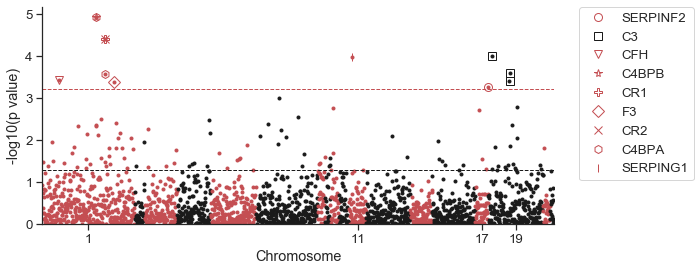

In [39]:
sns.set(style='ticks', font_scale=1.2)
plt.figure(figsize=(10,4))

neglog10 = lambda p: -1*np.log10(p)

chromosomes = sorted(set(map(int,list(zip(*plink_results))[0])))

start_pos = 0
alternate = 0
tick_positions = list()
tick_labels = list()

gene_markers = list()
sig_genes = set()

for this_chrom in chromosomes:
    
    unadjusted_pvalues = list()
    
    for chrom, rsid, allele, unadjusted, fdrbh in sorted(plink_results):
        if int(chrom) != this_chrom:
            continue
        
        unadjusted_pvalues.append(neglog10(unadjusted))
        
        if fdrbh < 0.05:
            for gene in rsid2gene[rsid]:
                gene_markers.append((gene, len(unadjusted_pvalues)+start_pos, unadjusted, alternate))
                sig_genes.add(gene)
    
    fmt = 'k.'
    if alternate % 2 == 0:
        fmt = 'r.'
    
    plt.plot(range(start_pos, start_pos+len(unadjusted_pvalues)) ,unadjusted_pvalues, fmt)

    if this_chrom in sig_chroms:
        tick_positions.append(len(unadjusted_pvalues)/2+start_pos)
        tick_labels.append(this_chrom)
    
    start_pos += len(unadjusted_pvalues)
    alternate += 1
    
# plot the significant genes
markerstyles = ['o', 's', 'v', '*', 'P', 'D', 'x', 'h', '|']
legend_names = list()
for i, gene in enumerate(sig_genes):
    _, xpos, unadj, alternate = zip(*[(g,x,p,a) for g,x,p,a in gene_markers if g == gene])
    
    color = 'k'
    if alternate[0] % 2 == 0:
        color = 'r'
#     xpos += np.random.normal(0, 20, 1)
    plt.plot(xpos, list(map(neglog10,unadj)), lw=0, color='none', markeredgecolor=color, markersize=8, marker=markerstyles[i], label=gene)
    legend_names.append(gene)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

# Add some markers for where the significance threshold is
# and customize the tick marks and labels
un_alpha = neglog10(0.05)
# bh_alpha = neglog10(0.0007)
bh_alpha = neglog10(1.1*least_sig_sig)

plt.plot([0, len(plink_results)], [un_alpha, un_alpha], 'k--', lw=1)
plt.plot([0, len(plink_results)], [bh_alpha, bh_alpha], 'r--', lw=1)
plt.xlim(0,len(plink_results))
plt.ylim(0)
plt.ylabel('-log10(p value)')

plt.xticks(tick_positions, tick_labels)
plt.xlabel('Chromosome')

sns.despine()
plt.tight_layout()

plt.savefig('figures/ukbb_complwas_%s.pdf' % study)